In [1]:
import os
folder = "results/"
os.path.exists(folder)

True

In [2]:
import pandas as pd
import json

def load_results(filename):
    """Loads the results file and normalizes the metrics."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    
    # Normalize metrics: Extract 'exact_match' or 'em'
    if 'metrics' in df.columns:
        # Check one row to see which key exists
        sample_metric = df['metrics'].iloc[0]
        metric_key = 'exact_match' if 'exact_match' in sample_metric else 'em'
        
        df['exact_match'] = df['metrics'].apply(lambda x: x.get(metric_key, 0))
        df['f1'] = df['metrics'].apply(lambda x: x.get('f1_score', x.get('f1', 0)))
    if "parsed_answer" in df.columns:
        df["prediction"] = df["parsed_answer"] 
        
    return df[['id', 'question', 'exact_match', 'prediction', 'gold_answers']]

# File paths (update these if your paths are different)
base_file = folder + 'qwen_base_closedbook_full_results.json'
sft_file = folder + 'qwen_sft_closedbook_full_results.json'
cot_file = folder + 'qwen_ftcot_closedbook_full_results_1.json'

# Load dataframes
print("Loading files...")
try:
    df_base = load_results(base_file)
    df_sft = load_results(sft_file)
    df_cot = load_results(cot_file)
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the JSON files are in the current directory.")
    exit()

# Rename columns for merging
df_base = df_base.rename(columns={'exact_match': 'base_em', 'prediction': 'base_pred'})
df_sft = df_sft.rename(columns={'exact_match': 'sft_em', 'prediction': 'sft_pred'})
df_cot = df_cot.rename(columns={'exact_match': 'cot_em', 'prediction': 'cot_pred'})

# Merge DataFrames on 'id'
# We use inner join to ensure we only compare questions present in all files
merged = df_base[['id', 'question', 'base_em', 'base_pred']].merge(
    df_sft[['id', 'sft_em', 'sft_pred']], on='id'
).merge(
    df_cot[['id', 'cot_em', 'cot_pred']], on='id'
)

print(f"Successfully aligned {len(merged)} questions across all models.")

# --- Analysis ---

# 1. Overall Performance
print("\n--- Overall Accuracy (Exact Match) ---")
print(f"Base Model: {merged['base_em'].mean():.2%}")
print(f"SFT Model:  {merged['sft_em'].mean():.2%}")
print(f"CoT Model:  {merged['cot_em'].mean():.2%}")

# 2. Corrections (Wrong -> Right)
# How many did the specific model get RIGHT that the Base model got WRONG?
sft_fixed = merged[(merged['base_em'] == 0) & (merged['sft_em'] == 1)]
cot_fixed = merged[(merged['base_em'] == 0) & (merged['cot_em'] == 1)]

print("\n--- Improvement Analysis (Correcting Base Model Errors) ---")
print(f"SFT corrected {len(sft_fixed)} questions that Base got wrong.")
print(f"CoT corrected {len(cot_fixed)} questions that Base got wrong.")

# 3. Regressions (Right -> Wrong)
# How many did the specific model get WRONG that the Base model got RIGHT?
sft_broke = merged[(merged['base_em'] == 1) & (merged['sft_em'] == 0)]
cot_broke = merged[(merged['base_em'] == 1) & (merged['cot_em'] == 0)]

print("\n--- Regression Analysis (Breaking Correct Base Answers) ---")
print(f"SFT broke {len(sft_broke)} questions that Base originally got right.")
print(f"CoT broke {len(cot_broke)} questions that Base originally got right.")

# Optional: Export the improvements to inspect them
sft_fixed.to_csv('sft_improvements.csv', index=False)
cot_fixed.to_csv('cot_improvements.csv', index=False)

sft_broke.to_csv('sft_broke.csv', index=False)
cot_broke.to_csv('cot_broke.csv', index=False)

Loading files...
Successfully aligned 7405 questions across all models.

--- Overall Accuracy (Exact Match) ---
Base Model: 18.87%
SFT Model:  21.94%
CoT Model:  24.31%

--- Improvement Analysis (Correcting Base Model Errors) ---
SFT corrected 477 questions that Base got wrong.
CoT corrected 697 questions that Base got wrong.

--- Regression Analysis (Breaking Correct Base Answers) ---
SFT broke 249 questions that Base originally got right.
CoT broke 294 questions that Base originally got right.


In [3]:
print("Loading files...")
try:
    df_sft = load_results(sft_file)
    df_cot = load_results(cot_file)
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the JSON files are in the current directory.")
    exit()

# Rename columns for distinct merging
df_sft = df_sft.rename(columns={'exact_match': 'sft_em', 'prediction': 'sft_pred'})
df_cot = df_cot.rename(columns={'exact_match': 'cot_em', 'prediction': 'cot_pred'})

# Merge SFT and CoT DataFrames on 'id'
merged = df_sft[['id', 'question', 'sft_em', 'sft_pred', 'gold_answers']].merge(
    df_cot[['id', 'cot_em', 'cot_pred']], on='id'
)

print(f"Successfully aligned {len(merged)} questions between SFT and CoT.")

# --- Analysis: Finetune CoT vs Normal Finetune (SFT) ---

# 1. Overall Accuracy Comparison
print("\n--- Overall Accuracy (Exact Match) ---")
print(f"SFT Model: {merged['sft_em'].mean():.2%}")
print(f"CoT Model: {merged['cot_em'].mean():.2%}")

# 2. CoT Improvements (SFT Wrong -> CoT Right)
cot_wins = merged[(merged['sft_em'] == 0) & (merged['cot_em'] == 1)]

# 3. SFT Wins (SFT Right -> CoT Wrong)
sft_wins = merged[(merged['sft_em'] == 1) & (merged['cot_em'] == 0)]

# 4. Agreements
both_correct = merged[(merged['sft_em'] == 1) & (merged['cot_em'] == 1)]
both_wrong = merged[(merged['sft_em'] == 0) & (merged['cot_em'] == 0)]

print("\n--- Head-to-Head Comparison ---")
print(f"CoT Corrected (SFT Wrong -> CoT Right): {len(cot_wins)}")
print(f"SFT Prevailed (SFT Right -> CoT Wrong): {len(sft_wins)}")
print(f"Both Correct: {len(both_correct)}")
print(f"Both Wrong:   {len(both_wrong)}")

# Optional: Export the differences to CSV for manual inspection
if len(cot_wins) > 0:
    cot_wins.to_csv('cot_improvements_over_sft.csv', index=False)
    print("\nSaved 'cot_improvements_over_sft.csv'")

if len(sft_wins) > 0:
    sft_wins.to_csv('sft_wins_over_cot.csv', index=False)
    print("Saved 'sft_wins_over_cot.csv'")

Loading files...
Successfully aligned 7405 questions between SFT and CoT.

--- Overall Accuracy (Exact Match) ---
SFT Model: 21.94%
CoT Model: 24.31%

--- Head-to-Head Comparison ---
CoT Corrected (SFT Wrong -> CoT Right): 556
SFT Prevailed (SFT Right -> CoT Wrong): 381
Both Correct: 1244
Both Wrong:   5224

Saved 'cot_improvements_over_sft.csv'
Saved 'sft_wins_over_cot.csv'


In [4]:
sft_broke.head()

,id,question,base_em,base_pred,sft_em,sft_pred,cot_em,cot_pred
40,5a7a0e1e5542990783324e1a,Which dog's ancestors include Gordon and Irish...,1.0,Scotch Collie,0.0,Manchester Terrier,1.0,Scotch Collie
67,5ae7ba7a5542993210983f12,What is the name of the singer who's song was ...,1.0,Usher,0.0,Rihanna,0.0,Aerosmith
78,5a78bd9b554299078472774a,What nationality were social anthropologists A...,1.0,British,0.0,English,1.0,British
79,5a7625e8554299109176e66a,In which year was the King who made the 1925 B...,1.0,1865,0.0,1934,1.0,1865
89,5aba749055429901930fa7d8,What occupation do Chris Menges and Aram Avaki...,1.0,Director,0.0,film director,0.0,film director


In [5]:
import pandas as pd
import json

def load_results(filename, model_prefix):
    """Loads results and normalizes EM and Abstention columns."""
    with open(filename, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    # 1. Normalize Exact Match (EM)
    if 'metrics' in df.columns:
        # Check first row to see if key is 'exact_match' or 'em'
        sample_metric = df['metrics'].iloc[0]
        metric_key = 'exact_match' if 'exact_match' in sample_metric else 'em'
        df[f'{model_prefix}_em'] = df['metrics'].apply(lambda x: x.get(metric_key, 0))
    
    # 2. Normalize Abstention
    # If the file doesn't have 'is_abstention', assume False (it never abstains)
    if 'is_abstention' in df.columns:
        df[f'{model_prefix}_abstain'] = df['is_abstention']
    else:
        df[f'{model_prefix}_abstain'] = False
        
    return df[['id', f'{model_prefix}_em', f'{model_prefix}_abstain']]

# --- File Paths ---
# Replace 'qwen_new_model.json' with your actual new model filename
files = {
    'base': folder + 'qwen_base_closedbook_full_results.json',
    'sft': folder + 'qwen_sft_closedbook_full_results.json',
    'cot': folder + 'qwen_ftcot_closedbook_full_results_1.json',
    'new': folder + 'eval_results_hotpotqa-abstention-80-20_SHORT_lr0.0002_bs4_20251210_020244.json' 
}

# --- Load and Merge ---
print("Loading files...")
dfs = []
try:
    for prefix, fname in files.items():
        dfs.append(load_results(fname, prefix))
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Merge all dataframes on 'id'
merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on='id')

print(f"Aligned {len(merged)} questions across all models.")

# --- Analysis Function ---
def calculate_abstention_stats(df, ref_model):
    """
    Calculates Precision and Recall of abstention assuming 
    'Ref Model Wrong' is the ground truth for 'Should Abstain'.
    """
    # TP: Ref is Wrong (Should Abstain) AND New Model Abstained
    tp = len(df[(df[f'{ref_model}_em'] == 0) & (df['new_abstain'] == True)])
    
    # FP: Ref is Right (Should Answer) BUT New Model Abstained
    fp = len(df[(df[f'{ref_model}_em'] == 1) & (df['new_abstain'] == True)])
    
    # FN: Ref is Wrong (Should Abstain) BUT New Model Answered
    fn = len(df[(df[f'{ref_model}_em'] == 0) & (df['new_abstain'] == False)])
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    return {
        'Reference Model': ref_model.upper(),
        'Precision': f"{precision:.2%}",
        'Recall': f"{recall:.2%}",
        'TP (Good Abstain)': tp,
        'FP (Bad Abstain)': fp,
        'FN (Missed Abstain)': fn
    }

# --- Run Analysis ---
stats = []
stats.append(calculate_abstention_stats(merged, 'base'))
stats.append(calculate_abstention_stats(merged, 'sft'))
stats.append(calculate_abstention_stats(merged, 'cot'))

# Bonus: Intersection of Failures (Hardest Questions)
# Define "Hardest" as: Base Wrong AND SFT Wrong AND CoT Wrong
merged['all_others_wrong'] = (
    (merged['base_em'] == 0) & 
    (merged['sft_em'] == 0) & 
    (merged['cot_em'] == 0)
).astype(int)

# Create a temporary column to map "all_others_wrong=1" to "em=0" logic for the function
merged['hardest_em'] = 1 - merged['all_others_wrong']
stats.append(calculate_abstention_stats(merged, 'hardest'))

# Display Results
results_df = pd.DataFrame(stats)
print("\n--- Abstention Analysis (New Model) ---")
print(results_df.to_string(index=False))

# Optional: Save breakdown
results_df.to_csv('abstention_analysis.csv', index=False)

Loading files...
Aligned 7405 questions across all models.

--- Abstention Analysis (New Model) ---
Reference Model Precision Recall  TP (Good Abstain)  FP (Bad Abstain)  FN (Missed Abstain)
           BASE    97.49% 55.69%               3346                86                 2662
            SFT    95.72% 56.83%               3285               147                 2495
            COT    93.97% 57.54%               3225               207                 2380
        HARDEST    90.53% 60.85%               3107               325                 1999


Loading files...
Aligned 7405 questions across all models.
Confusion matrices with metrics saved to 'abstention_confusion_matrices_large.png'


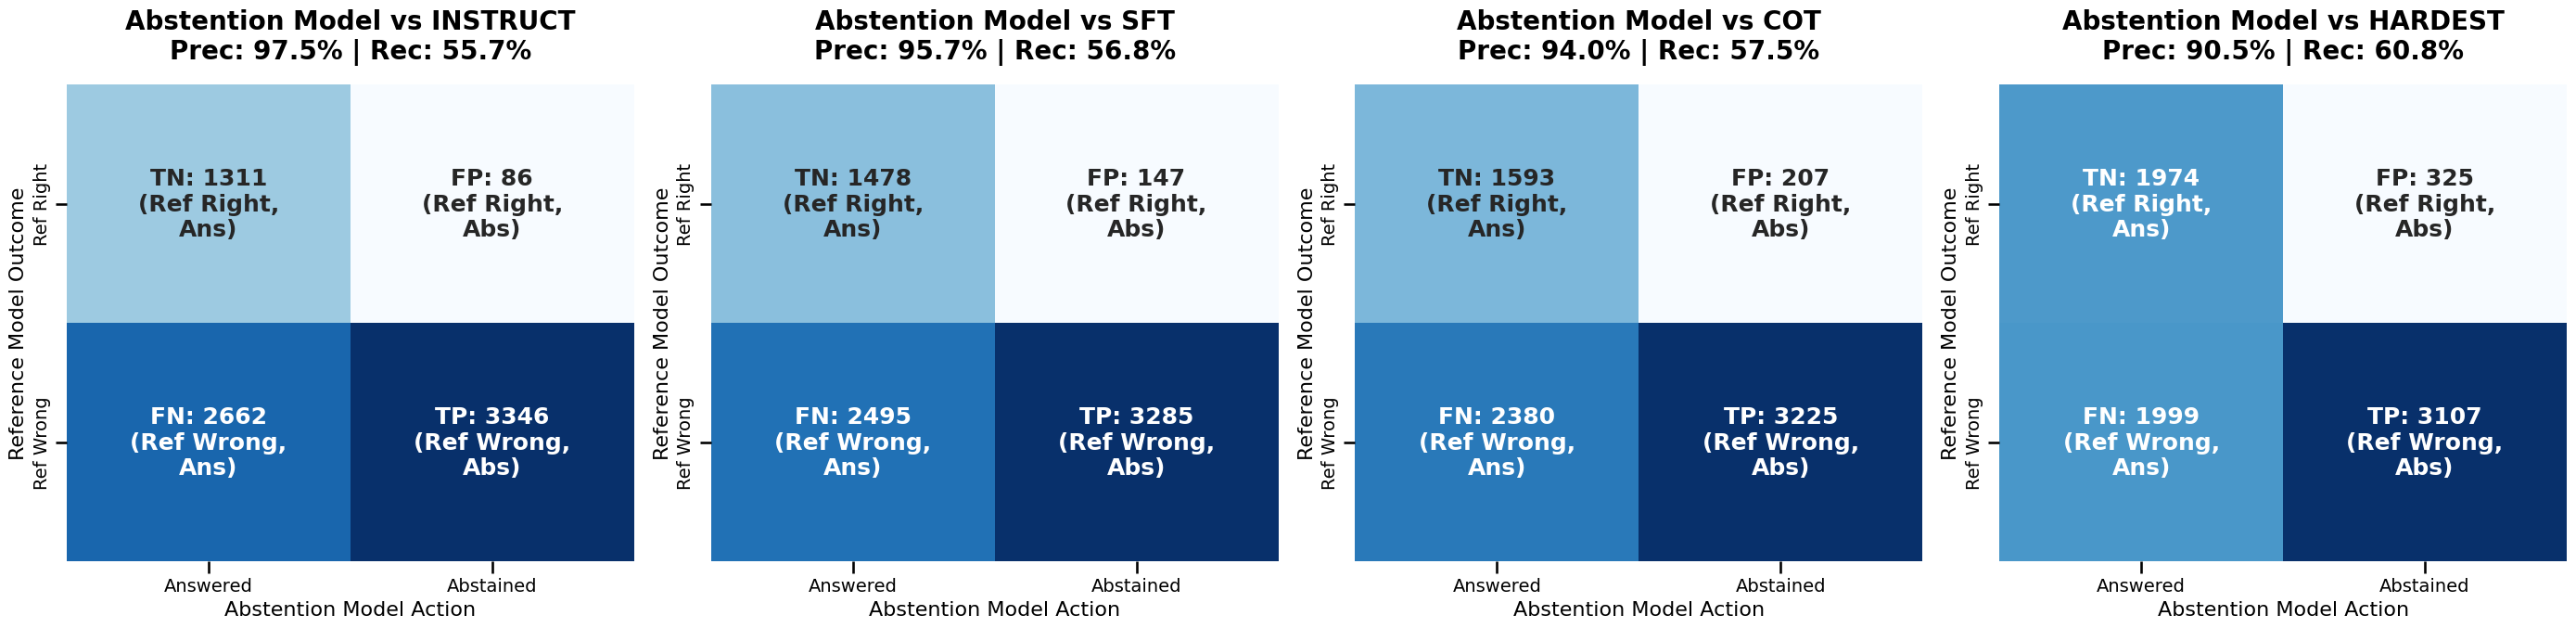

In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- Configuration ---
# Set global font scale for better readability
sns.set_context("talk", font_scale=1.1)
plt.rcParams.update({'font.size': 14})

def load_results(filename, model_prefix):
    """Loads results and normalizes EM and Abstention columns."""
    with open(filename, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    # 1. Normalize Exact Match (EM)
    if 'metrics' in df.columns:
        # Check first row to see if key is 'exact_match' or 'em'
        sample_metric = df['metrics'].iloc[0]
        metric_key = 'exact_match' if 'exact_match' in sample_metric else 'em'
        df[f'{model_prefix}_em'] = df['metrics'].apply(lambda x: x.get(metric_key, 0))
    
    # 2. Normalize Abstention
    if 'is_abstention' in df.columns:
        df[f'{model_prefix}_abstain'] = df['is_abstention']
    else:
        df[f'{model_prefix}_abstain'] = False
        
    return df[['id', f'{model_prefix}_em', f'{model_prefix}_abstain']]

# --- File Paths ---
# folder = './' # Ensure this is defined
files = {
    'instruct': folder + 'qwen_base_closedbook_full_results.json', # Renamed key to 'instruct'
    'sft': folder + 'qwen_sft_closedbook_full_results.json',
    'cot': folder + 'qwen_ftcot_closedbook_full_results_1.json',
    'new': folder + 'eval_results_hotpotqa-abstention-80-20_SHORT_lr0.0002_bs4_20251210_020244.json' 
}

# --- Load and Merge ---
print("Loading files...")
dfs = []
try:
    for prefix, fname in files.items():
        dfs.append(load_results(fname, prefix))
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on='id')

print(f"Aligned {len(merged)} questions across all models.")

# --- Confusion Matrix Visualization ---

# Define Comparisons (Updated 'base' -> 'instruct')
comparisons = ['instruct', 'sft', 'cot', 'hardest']

# Calculate "Hardest" (All reference models wrong)
# Updated column name from 'base_em' to 'instruct_em'
merged['all_others_wrong'] = (
    (merged['instruct_em'] == 0) & 
    (merged['sft_em'] == 0) & 
    (merged['cot_em'] == 0)
).astype(int)

# Set up the plot area
fig, axes = plt.subplots(1, 4, figsize=(28, 7))

for i, ref in enumerate(comparisons):
    # 1. Define "Ground Truth" for Abstention
    # "Positive" (1) = We SHOULD Abstain (because Ref model is Wrong)
    # "Negative" (0) = We SHOULD Answer (because Ref model is Right)
    if ref == 'hardest':
        y_true = merged['all_others_wrong'] # 1 if all wrong
    else:
        y_true = 1 - merged[f'{ref}_em']    # 1 if wrong, 0 if right
        
    # 2. Define Prediction
    # "Positive" (1) = Model Abstained
    # "Negative" (0) = Model Answered
    y_pred = merged['new_abstain'].astype(int)
    
    # 3. Compute Matrix
    # Labels: [0, 1] -> [Should Answer, Should Abstain]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # 4. Calculate Precision and Recall
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # 5. Create Custom Annotations (Large Text)
    annot_text = [
        f"TN: {tn}\n(Ref Right,\nAns)",     f"FP: {fp}\n(Ref Right,\nAbs)",
        f"FN: {fn}\n(Ref Wrong,\nAns)",     f"TP: {tp}\n(Ref Wrong,\nAbs)"
    ]
    annot_text = np.array(annot_text).reshape(2, 2)
    
    # 6. Plot Heatmap
    sns.heatmap(cm, annot=annot_text, fmt='', ax=axes[i], cmap='Blues', cbar=False,
                annot_kws={"size": 18, "weight": "bold"},
                xticklabels=['Answered', 'Abstained'],
                yticklabels=['Ref Right', 'Ref Wrong'])
    
    # 7. Titles and Labels
    title_text = f"Abstention Model vs {ref.upper()}\nPrec: {precision:.1%} | Rec: {recall:.1%}"
    axes[i].set_title(title_text, fontsize=20, pad=20, fontweight='bold')
    axes[i].set_xlabel("Abstention Model Action", fontsize=16)
    axes[i].set_ylabel("Reference Model Outcome", fontsize=16)
    
    # Tick Label Size
    axes[i].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
output_filename = 'abstention_confusion_matrices_large.png'
plt.savefig(output_filename)
print(f"Confusion matrices with metrics saved to '{output_filename}'")
plt.show()